In [1]:
from collections import defaultdict
from pymongo import MongoClient

client = MongoClient()
db = client["senators"]
coll = db["raw_xml"]

In [ ]:
import requests
import time
import sys

def try_request(url, retries=0):
    if retries == 10:
        print url
    if retries > 15:
        print url
        return None
    req = requests.get(url, headers={
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:39.0) Gecko/20100101 Firefox/39.0'
        })
    try:
        etree.fromstring(req.content)
        return req.content
    except:
        time.sleep(retries)
        return try_request(url, retries+1)

# Load senate data

for cong in range(101,115):
    for sess in range(1,3):
        root = etree.fromstring(try_request("http://www.senate.gov/legislative/LIS/roll_call_lists/vote_menu_{}_{}.xml".format(cong, sess)))

        for vote_num in root.xpath("votes/vote/vote_number"):
            if not coll.find_one({"congress": cong, "session": sess, "vote_num": vote_num.text}):
                print cong, sess, vote_num.text
                sys.stdout.flush()
            
                raw_xml = try_request("http://www.senate.gov/legislative/LIS/roll_call_votes/vote{cong}{sess}/vote_{cong}_{sess}_{vote_num}.xml".format(cong=cong, sess=sess, vote_num=vote_num.text))
                roll_call_vote = etree.fromstring(raw_xml)
                member_votes = []
                for member in roll_call_vote.xpath("members/member"):
                    name = member.find("member_full").text
                    vote = member.find("vote_cast").text
                    if vote=='Yea':
                        vote_score = 1
                    elif vote=='Nay':
                        vote_score = -1
                    else:
                        vote_score = 0
                    member_votes.append({ 
                            "name": name,
                            "vote_cast": vote,
                            "vote_score": vote_score
                        })
                coll.insert_one({
                            "raw": raw_xml,
                            "congress": cong,
                            "session": sess,
                            "vote_num": vote_num.text,
                            "votes": member_votes
                    })

In [2]:
votes = defaultdict(dict)

for roll_call in coll.find({"congress": 113},{"raw":0}):
    for member in roll_call["votes"]:
        votes[member["name"]][(roll_call["session"],roll_call["vote_num"])] = member["vote_score"]

In [3]:
from sklearn.feature_extraction import DictVectorizer

senator_names = votes.keys()
senators = [votes[name] for name in senator_names]
dict_vectorizer = DictVectorizer()
features = dict_vectorizer.fit_transform(senators)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [4]:
from sklearn.cluster import AgglomerativeClustering

labels = AgglomerativeClustering().fit_predict(features.toarray())

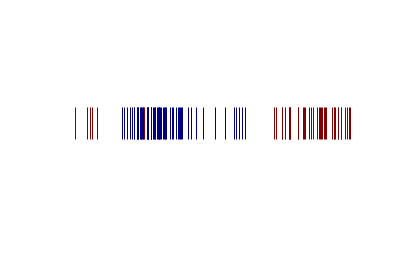

In [5]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import numpy as np
import random

mds = MDS(n_components=1)
partisanship = mds.fit_transform(features.toarray())

%matplotlib inline
plt.scatter(partisanship, np.zeros_like(partisanship), c=labels,marker="|",s=1000)
# y=np.ones(np.shape(partisanship))
# plt.plot(partisanship,y,"|",ms=40,c=labels)
plt.axis("off")

# for name, val in zip(senator_names, partisanship)[0:2]:
#     plt.annotate(name, xy = (val, 0), xytext = (0, 1),
#         textcoords = 'offset points', ha = 'right', va = 'bottom')
plt.show()

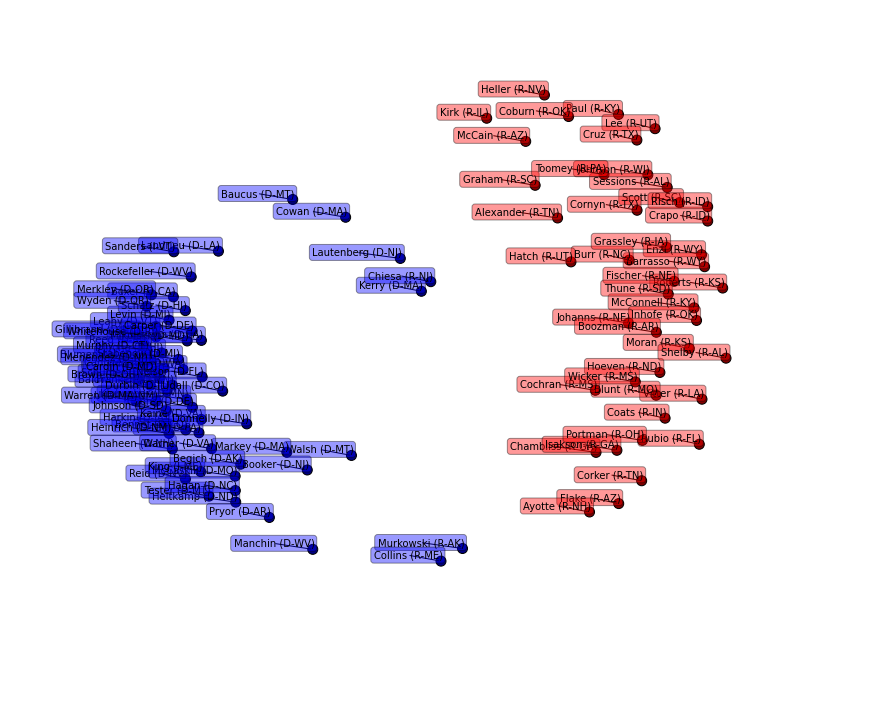

In [22]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0,12.0)

mds = MDS()
coords = mds.fit_transform(features.toarray())
plot = plt.scatter(coords[:,0], coords[:,1], c=labels, s=100)
plt.axis("off")

for i, (name, xy) in enumerate(zip(senator_names, coords)):
    color = "red" if labels[i] else "blue"
    plt.annotate(name, xy = xy, xytext = (1, 1),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.3', fc=color,alpha = .4),
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=0')
    )